<h1><left><font size="5">Forecasting Laboratory Earthquakes Using Seismic Acoustic Time-Series: Continuation (v2)</font>
    <h2><left><font size="4">Data Source & Host: Los Alamos National Laboratory</font></left></h2>

# <a id='0'>Contents</a>

- <a href='#1'>Import Packages</a>    
- <a href='#2'>Re: Signal Processing & Feature engineering</a>
- <a href='#3'>Re: GBM Model</a>
- <a href='#4'>Submission File</a>  

# <a id='1'>Import Packages</a>

In [67]:
import os 
import time
import csv
import warnings
import numpy as np
from numpy.fft import rfft
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import lightgbm as lgb
from joblib import dump, load
import dask
import dask_searchcv as dcv
from scipy import stats
from scipy.signal import hann, hilbert, convolve 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, GridSearchCV, TimeSeriesSplit
from collections import deque, defaultdict
from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
pd.options.display.precision = 10
%matplotlib inline

# <a id='2'>Re: Signal Processing & Feature engineering</a>

In [2]:
def get_features(signal):
    
    def power(sig):
        return sum(map(lambda x: x**2, sig))
        
    features = pd.DataFrame({'power': power(signal),
                             'mean': signal.mean(),
                             'var': signal.var(),
                             'std': signal.std(),
                             'kurtosis': stats.kurtosis(signal, fisher=False),
                             'max': max(abs(signal))                             
                            }, index=[0]).astype('float32')
    return features

In [3]:
def get_max_deque(signal):
    signal = abs(signal.values)
    max_dq = deque()
    max_dq.append(signal[-1])
    for i in range(2,len(signal)+1):
        if signal[-i] > max_dq[0]:
            max_dq.appendleft(signal[-i])
        else:
            max_dq.appendleft(max_dq[0])
    return max_dq


def power(sig):
    return sum(map(lambda x: x**2, sig))


reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
window = reader.get_chunk(150_000)
signal = window.acoustic_data
target = [window.time_to_failure.iloc[-1]]
interval = 500
m0 = signal.mean()
chunks = deque()
for i in range((150_000//interval)):
    partition = signal[i*interval:(i+1)*interval]
    chunks.append({'power_component': power(partition),
                   'mean_component':  sum(partition)/150_000
                   })

training_data = get_features(signal)
current = {'power':training_data['power'][0],
           'mean': training_data['mean'][0],
          }

iterations = (629_145_480-150_000)//interval
full_max_deque = get_max_deque(signal)
for _ in tqdm_notebook(range(iterations), desc='Feature Extraction'):

    #pop out oldest interval chunk, get new chunk and add to chunk list
    previous_chunk = chunks.popleft()
    window = reader.get_chunk(interval)
    new_chunk = {'power_component': power(window.acoustic_data),
                 'mean_component':  sum(window.acoustic_data)/150_000
                }
    chunks.append(new_chunk)

    # append new target variable
    target.append(window.time_to_failure.iloc[-1])

    # use oldest and new chunk to compute all current window features except max
    current_power = current['power'] - previous_chunk['power_component'] + new_chunk['power_component']
    current_mean = current['mean'] - previous_chunk['mean_component'] + new_chunk['mean_component']
    signal = signal[interval:].append(window.acoustic_data)
    Moment_1 = signal-current_mean
    current_var = sum(Moment_1**2)/150_000
    current_std = current_var**0.5
    current_kurtosis = sum(Moment_1**4)/150_000/current_var**2

    # update current power and mean
    current['power'] = current_power
    current['mean'] = current_mean

    # Max function 
    # get max_deque of new interval data
    interval_max_deque = get_max_deque(window.acoustic_data)
    
    # reassess max values for full deque
    if interval_max_deque[0] >= full_max_deque[interval]:
        full_max_deque = deque([interval_max_deque[0]]*150_000)
    else:
        i = -1
        while full_max_deque[i] < interval_max_deque[0]:
            full_max_deque[i] = interval_max_deque[0]
            i -= 1
        
    # popoff old interval elements and join new interval elements
    for i in range(interval):
        full_max_deque.popleft()
        full_max_deque.append(interval_max_deque[i])

    train_row = pd.DataFrame({'power': current_power,
                              'mean':  current_mean,
                              'var':   current_var,
                              'std':   current_std,
                              'kurtosis': current_kurtosis,
                              'max': full_max_deque[0] }, index = [0]).astype('float32')
        
    training_data = pd.concat([training_data,train_row], ignore_index=True, axis=0)

In [4]:
training_data.to_csv('feature_v2.csv',index=False)
pd.Series(target).to_csv('target_v2.csv',index=False)

In [3]:
def get_fourier(signal):
    trans_signal = (signal-signal.mean())*hann(150_000)
    # compute real FFT and take lower frequnecies of interest
    coefficients = np.fft.rfft(trans_signal)[1:16668]
    return abs(coefficients)

# <a id='3'>Re: GBM Model</a>

In [47]:
param_grid = [{'learning_rate': [0.03, 0.06, 0.12], 
              'num_leaves':[20, 40],
              'min_data_in_leaf': [2000, 5000, 15_000],
              'n_estimators': [100,300,500],
              'max_depth':[4, 8]
              }, 
              {'learning_rate': [0.06, 0.1, 0.3], 
              'num_leaves':[100, 300],
              'min_data_in_leaf': [500, 1000],
              'n_estimators': [50, 100],
              'max_depth':[8, 10]
              }] 

In [85]:
model = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                     param_grid=param_grid, 
                     cv=TimeSeriesSplit(n_splits=5), 
                     scoring='neg_mean_absolute_error',
                     n_jobs=-1,
                     verbose=10,
                     return_train_score=True)

In [86]:
model.fit(training_data,target)

Fitting 5 folds for each of 156 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': [0.03, 0.06, 0.12], 'num_leaves': [20, 40], 'min_data_in_leaf': [2000, 5000, 15000], 'n_estimators': [100, 300, 500], 'max_depth': [4, 8]}, {'learning_rate': [0.06, 0.1, 0.3], 'num_leaves': [100, 300], 'min_data_in_leaf': [500, 1000], 'n_estimators': [50, 100], 'max_depth': [8, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg

In [51]:
def plot_model_train_cv_error(model):
    fig = plt.figure(figsize=(16,6))
    plt.title('Mean Training & CV Error')
    plt.xlabel('Model Number')
    plt.ylabel('ylabelative Mean Absolute Error')
    plt.plot(model.cv_results_['mean_train_score'], color='g', label='Training')
    plt.legend(loc=(0.75, 0.90))
    plt.plot(model.cv_results_['mean_test_score'], color='r', label='CV')
    plt.legend(loc=(0.75, 0.85))

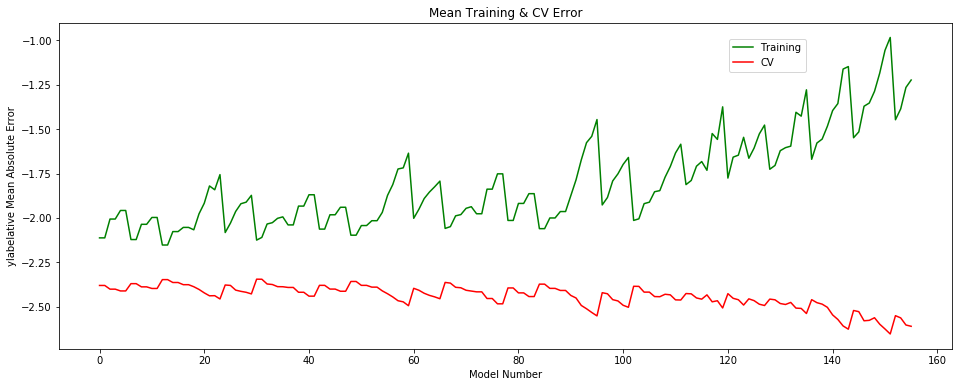

In [106]:
plot_model_train_cv_error(model)

In [97]:
model.best_params_

{'learning_rate': 0.03,
 'max_depth': 8,
 'min_data_in_leaf': 15000,
 'n_estimators': 100,
 'num_leaves': 20}

In [62]:
def plot_feature_importance(model, importance='gain'):
    M1 = lgb.LGBMRegressor(**model.best_params_, importance_type=importance)
    M1.fit(training_data, target)
    ranked_features_ndx = sorted(range(len(M1.feature_importances_)), key=lambda x: M1.feature_importances_[x])


    objects = [training_data.keys()[i] for i in ranked_features_ndx]
    y_pos = np.arange(len(objects))
    importance = [M1.feature_importances_[i] for i in ranked_features_ndx]

    fig = plt.figure(figsize=(16,4))
    plt.barh(y_pos, importance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Gain')
    plt.title('Feature Importance')

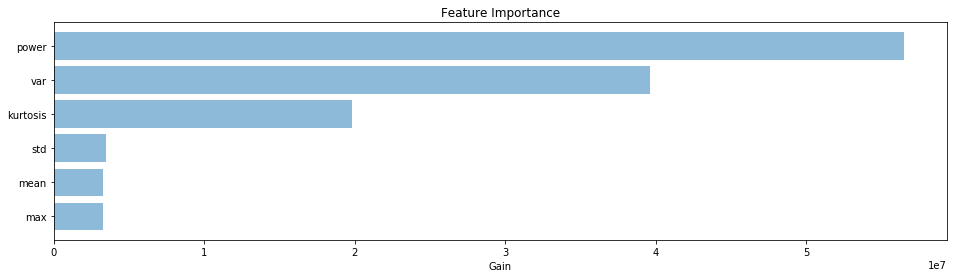

In [107]:
plot_feature_importance(model)

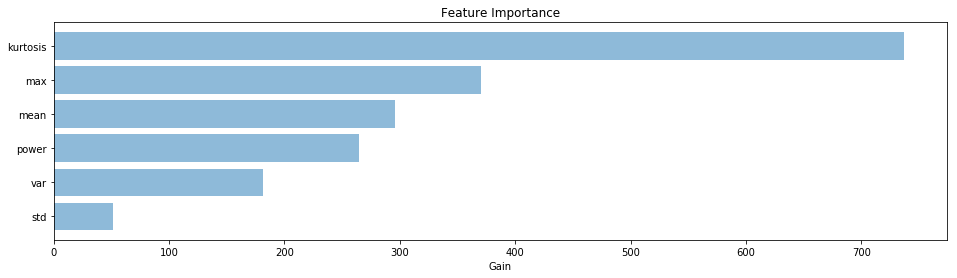

In [108]:
plot_feature_importance(model,importance='split')

In [109]:
path = './test'
with open('submission2.csv', 'a', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['seg_id','time_to_failure'])
    
    for seg in tqdm_notebook(os.listdir(path), desc='Creating Submission'):
        data = pd.read_csv(path+'/'+seg).acoustic_data
        features = get_features(data)
        prediction = model.predict(features)
        wr.writerow([seg.split('.')[0] , prediction[0]])